In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)  
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['figure.figsize'] = 10, 10
matplotlib.rcParams['text.color'] = 'k'

import time
import requests #for api requests
import flair
#sentiment_model = flair.models.TextClassifier.load('en-sentiment') BERT traditional sentiment model more accurate, longer time to process
sentiment_model = flair.models.TextClassifier.load('sentiment-fast')# for fast sentiment analysis
import re #for regex
from datetime import datetime, timedelta #for date manipulation



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.o

2021-06-26 10:48:50,819 loading file C:\Users\h.pineda\.flair\models\sentiment-en-mix-ft-rnn.pt


In [2]:
#response_tweet.json()

In [3]:
def get_data(tweet):
    data = {
        'id': tweet['id_str'],
        'created_at': tweet['created_at'],
        'text': tweet['full_text']
    }
    return data

In [4]:
def get_data_v2(tweet):
    data = {
        'id': tweet['id'],
        'created_at': tweet['created_at'],
        'text': tweet['text']
    }
    return data

In [5]:
def clean_tweets(tweet):
    web_address = re.compile(r"(?i)http(s):\/\/[a-z0-9.~_\-\/]+") #cleans web addresses
    tweet = web_address.sub('', tweet)
    emoticons = [word for word in re.findall('\w+',tweet) if len(word) > 1] #\w+ keep all words w letters +: attach each word at a time
    tweet_lower = ' '.join(emoticons).lower()
    return tweet_lower

In [6]:
def sentiment_generator(tweets):
    probs = []
    sentiments = []

# use regex expressions (in clean function) to clean tweets
    tweets['text'] = tweets['text'].apply(clean_tweets)

    for tweet in tweets['text']:
        # make prediction
        sentence = flair.data.Sentence(tweet)
        sentiment_model.predict(sentence)
        # extract sentiment prediction
        probs.append(sentence.labels[0].score)  # numerical score 0-1
        sentiments.append(sentence.labels[0].value)  # 'POSITIVE' or 'NEGATIVE'

    # add probability and sentiment predictions to tweets dataframe
    tweets['probability'] = probs
    tweets['sentiment'] = sentiments
    return tweets

In [7]:
def sentiment_generator_fast(tweets):
    
    probs = []
    sentiments = []

# use regex expressions (in clean function) to clean tweets
    tweets['text'] = tweets['text'].apply(clean_tweets)

    sentences = [flair.data.Sentence(tweet) for tweet in tweets['text']]
    sentiment_model.predict(sentences, mini_batch_size=32)  # make prediction
    for sent in sentences: 
        # extract sentiment prediction
        probs.append(sent.labels[0].score)  # numerical score 0-1
        sentiments.append(sent.labels[0].value)  # 'POSITIVE' or 'NEGATIVE'

    # add probability and sentiment predictions to tweets dataframe
    tweets['probability'] = probs
    tweets['sentiment'] = sentiments
    return tweets

In [8]:
def time_travel(now, mins):
    dtformat = '%Y-%m-%dT%H:%M:%SZ'
    now = datetime.strptime(now, dtformat)
    back_in_time = now - timedelta(minutes=mins,seconds=10)
    return back_in_time.strftime(dtformat)

In [90]:
def crypto_tweets(name):
    #twitter_key = 'BB6MLPHASHDY73PG'
    bearer_token = 'AAAAAAAAAAAAAAAAAAAAAGQtRAEAAAAAgFzyHyNeN6DEOaOZAZHpnxnocMA%3DVCnNVxCs7qmStPlVxTTkJmJSZ8J1wZI32y2b2G45qPSCe1kwH6'
    endpoint = 'https://api.twitter.com/2/tweets/search/recent'
    headers = {'authorization': 'Bearer '+bearer_token}
    params = {
        'query': f'({name}) (lang:en)',
        'max_results': '100',
        'tweet.fields': 'created_at,lang'
    }

    dtformat = '%Y-%m-%dT%H:%M:%SZ'  # the date format string required by twitter

    # we use this function to subtract 60 mins from our datetime string

    now = datetime.utcnow() - timedelta(seconds=10) # get the current datetime, this is our starting point convert to UTC 
    last_week = now - timedelta(days=6,seconds=10)  # datetime one week ago = the finish line
    now = now.strftime(dtformat)  # convert now datetime to format for API

    df1 = pd.DataFrame()  # initialize dataframe to store tweets

    while True:
        if datetime.strptime(now, dtformat) < last_week:
            # if we have reached 7 days ago, break the loop
            break
        pre60 = time_travel(now, 60)  # get 60 minutes before 'now'
        # assign from and to datetime parameters for the API
        params['start_time'] = pre60
        params['end_time'] = now
        response = requests.get(endpoint,
                                params=params,
                                headers=headers)  # send the request
        now = pre60  # move the window 60 minutes earlier
        # iteratively append our tweet data to our dataframe

        for tweet in response.json()['data']:
            row = get_data_v2(tweet)  # we defined this function earlier
            df1 = df1.append(row, ignore_index=True)
    df1_sentiment = sentiment_generator_fast(df1)
    return df1_sentiment
        

In [10]:
def crypto_price_hour(symbol):
    #x = input('Input cryptocurrency symbol:')
    key = 'BB6MLPHASHDY73PG'
    inputs = {
      'function' : 'CRYPTO_INTRADAY',
     'symbol' : symbol,
     'market' : 'USD',
     'interval': '60min',
     'apikey' : key,   
     'outputsize': 'full'
    }

    response = requests.get("https://www.alphavantage.co/query",inputs)
    data = pd.DataFrame(response.json()['Time Series Crypto (60min)'])
    data = pd.DataFrame(response.json()['Time Series Crypto (60min)']).T
    data = data.drop(columns=['2. high', '3. low', '4. close', '5. volume'], axis=1)
    data = data.apply(pd.to_numeric)
    data = data.round(decimals=6)
    data = data.sort_index(ascending=True)
    return data

In [11]:
#Created this function to get the daily price and add price to sentiment daily average to get correlation score
def crypto_price_day(symbol):
    #x = input('Input cryptocurrency symbol:')
    key = 'BB6MLPHASHDY73PG'
    inputs = {
      'function' : 'DIGITAL_CURRENCY_DAILY',
     'symbol' : symbol,
     'market' : 'USD',
     'apikey' : key,   
     'outputsize': 'full'
    }

    response = requests.get("https://www.alphavantage.co/query",inputs)
    data = pd.DataFrame(response.json()['Time Series (Digital Currency Daily)']).T
    
    data = data.drop(columns=['1b. open (USD)', '2a. high (USD)', '2b. high (USD)',
       '3a. low (USD)', '3b. low (USD)', '4a. close (USD)', '4b. close (USD)',
       '5. volume', '6. market cap (USD)'], axis=1)
    data.rename(columns = {'1a. open (USD)': 'price'}, inplace = True) 
    data = data.apply(pd.to_numeric)
    data = data.round(decimals=6)
    data = data.sort_index(ascending=True)
    return data

In [12]:
def sentiment_daily_avg(price, sentiment):
#get average price to scale sentiment score
    coin_mean = price['1. open'].mean()
#clean data frame
    sentiment = sentiment.drop(columns=['id', 'text'], axis=1)
    sentiment['created_at'] = pd.to_datetime(sentiment['created_at'])
#transform data frame
    sentiment.loc[sentiment['sentiment'] == 'NEGATIVE' , 'probability'] *= -coin_mean + coin_mean
    sentiment.loc[sentiment['sentiment'] == 'POSITIVE' , 'probability'] *= coin_mean +coin_mean
    sentiment = sentiment.drop(columns=['sentiment'])
    sentiment = sentiment.sort_index(ascending=False)
#convert index to year-month-day
    sentiment['created_at'] = sentiment['created_at'].dt.date
#group by day and get daily average    
    sentiment= sentiment.groupby(by=['created_at']).mean()
#add hours minutes seconds to index to start at 23 at each day for plot
    sentiment.index = [str(i)+ ' 23:00:00' for i in sentiment.index]
    return sentiment

In [42]:
# Adjusted to get correlation score
def sentiment_daily_avg_corr(price_hour, sentiment):
#get average price to scale sentiment score
    coin_mean = price_hour['1. open'].mean()
#clean data frame
    sentiment = sentiment.drop(columns=['id', 'text'], axis=1)
    sentiment['created_at'] = pd.to_datetime(sentiment['created_at'])
#transform data frame
    sentiment.loc[sentiment['sentiment'] == 'NEGATIVE' , 'probability'] *= -coin_mean + coin_mean
    sentiment.loc[sentiment['sentiment'] == 'POSITIVE' , 'probability'] *= coin_mean +coin_mean
    sentiment = sentiment.drop(columns=['sentiment'])
    sentiment = sentiment.sort_index(ascending=False)
#convert index to year-month-day
    sentiment['created_at'] = sentiment['created_at'].dt.date
#group by day and get daily average    
    sentiment= sentiment.groupby(by=['created_at']).mean()
    return sentiment

In [115]:
#Correlation coeff based on the sentiment daily average, vs daily price dataframe
def price_sentiment_corr(price_hour, price_day, sentiment):
    #Get table sentiment daily average dataframe 
    sentiment_avg = sentiment_daily_avg_corr(price_hour, sentiment)
    #prepare daily price column to add to sentiment_avg dataframe
    price_day_adjusted = price_day.loc[str(sentiment_avg.index[0]):str(sentiment_avg.index[-1])]
    #add price column 
    sentiment_avg['price'] = price_day_adjusted['price'].values
    corr_matrix = sentiment_avg.corr()
    x_corr = corr_matrix['price']  
    correlation = round(x_corr['probability'],2)
    return f'Correlation coefficient vs daily: {correlation}'

In [116]:
#Correlation coeff based on the sentiment daily average, vs 24-hour average price of the hourly price dataframe
def price_sentiment_corr_2(price_hour, sentiment):
    #Get table sentiment daily average dataframe 
    sentiment_avg = sentiment_daily_avg_corr(price_hour, sentiment)
    #Get daily average dataframe from the hourly price dataframe
    price_hour['index'] = price_hour.index
    price_hour['index'] = pd.to_datetime(price_hour['index'])
    price_hour['index'] = price_hour['index'].dt.date
    price_hour = price_hour.groupby(by=['index']).mean()
    price_hour.index = price_hour.index.map(str)
    #prepare daily price column to add to sentiment_avg dataframe
    price_hour_adjusted = price_hour.loc[str(sentiment_avg.index[0]):str(sentiment_avg.index[-1])]
    #add price column 
    sentiment_avg['price'] = price_hour_adjusted['1. open'].values
    corr_matrix = sentiment_avg.corr()
    x_corr = corr_matrix['price']  
    correlation = round(x_corr['probability'],2)
    return f'Correlation coefficient vs 24-hour average: {correlation}'

In [25]:
ph = crypto_price_hour('btc')

In [125]:
phtest = ph.copy()

In [126]:
phtest['index'] = pd.to_datetime(phtest['index'])
phtest['index'] = phtest['index'].dt.date
phtest = phtest.groupby(by=['index']).mean()

In [127]:
phtest.head()

,1. open
index,
2021-05-15,48122.050000
2021-05-16,47658.715417
2021-05-17,44342.585000
2021-05-18,44166.228333
2021-05-19,39274.547917


In [122]:
pday = crypto_price_day('btc')

In [28]:
what = crypto_tweets('bitcoin')

In [128]:
sentiment_daily_avg_corr(ph, what)

,probability
created_at,
2021-06-22,25424.880249
2021-06-23,31878.223138
2021-06-24,32610.601951
2021-06-25,31543.890263
2021-06-26,35239.546476


In [129]:
price_sentiment_corr(ph, pday, what)

'Correlation coefficient vs daily: 0.18'

In [118]:
price_sentiment_corr_2(ph, what)

'Correlation coefficient vs 24-hour average: 0.12'

In [21]:
def plot_sentiment_price(price, sentiment):
#price plot to start 12 hours before the sentiment daily average plot. 
    time = sentiment.index[0]
    time = time.replace('23:00:00','12:00:00')
    price = price.loc[time:]
#plot code
    x = price.index
    y = price['1. open']
    tick_spacing = 25
#figsize(x,y) adjusted to make x-axis value readable 
    fig, ax = plt.subplots(1,1, figsize=(15,6), dpi=100)
    ax.plot(x,y, label = 'cryptocurrency')
    ax.set_ylabel('Open')
    ax.set_xlabel('Datetime')
    ax.plot(sentiment.index,sentiment['probability'], label='sentiment')
    ax.legend()
    ax.set_title('Price vs Sentiment')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    plt.tight_layout()
    plt.show()
    return fig.savefig('fig1.png')

In [91]:
def do_everything():
    symbol = input('Input cryptocurrency symbol:')
    coin = input('Search cryptocurrency on twitter:')
    price_hour = crypto_price_hour(symbol)
    price_day = crypto_price_day(symbol)
    crypto_df = crypto_tweets(coin)
    sentiment = sentiment_daily_avg(price_hour, crypto_df)
    corr = price_sentiment_corr(price_hour, price_day, crypto_df)
    corr2 = price_sentiment_corr_2(price_hour, crypto_df)
    plot_sentiment_price(price_hour, sentiment)
    return corr, corr2

Input cryptocurrency symbol:btc
Search cryptocurrency on twitter:bitcoin


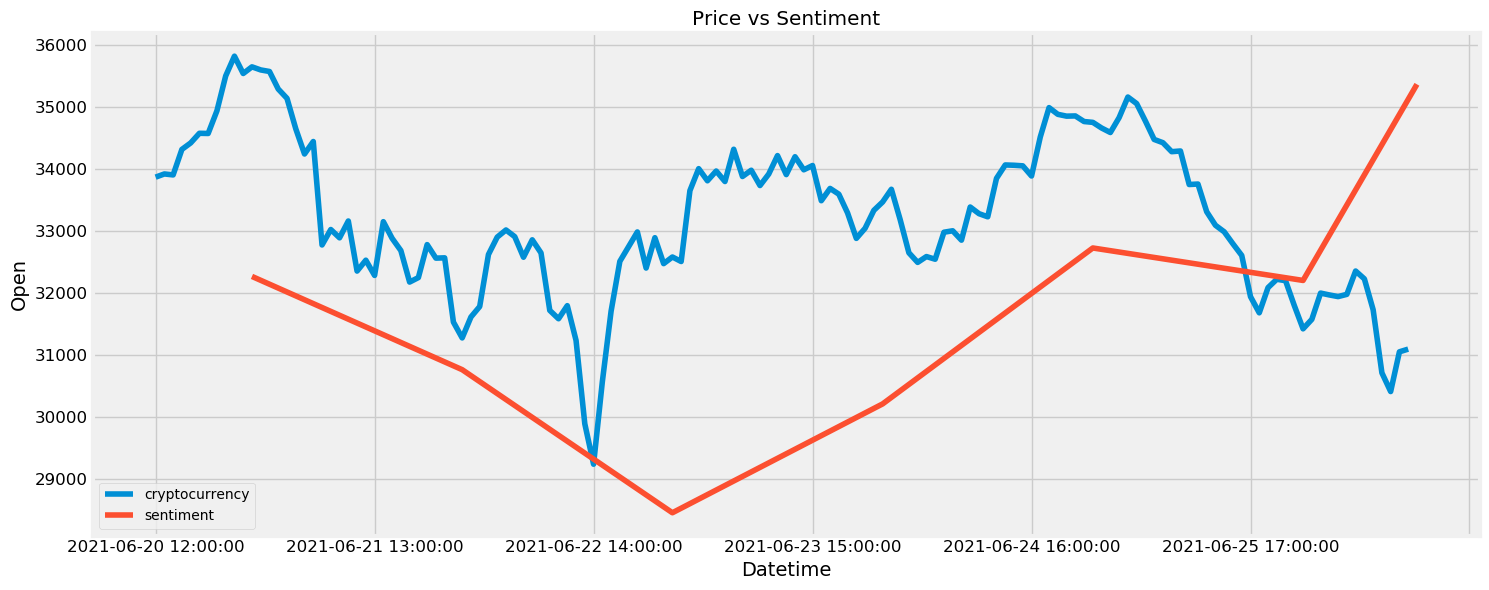

('Correlation coefficient vs daily: 0.02',
 'Correlation coefficient vs 24-hour average: -0.08')

In [132]:
do_everything()